## RNN
### 영화 리뷰 감정 분석&  Seq2Seq기계번역

- 순차적 데이터 혹은 시계열 데이터 다룸
- RNN은 정해지지 않은 길이의 배열을 읽고 설명하는 신경망

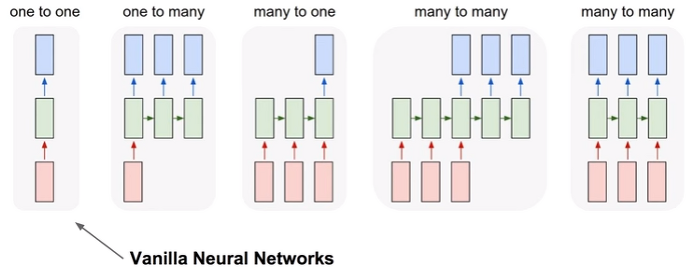

In [1]:
## 여러 형태의 RNN
from IPython.display import Image
Image("RNN_.png")

- one to one 일반적으로 보아온 신경망이나 CNN => vanilla Neural Networks
- many to one: 분류 문제
- many to many: 문법태깅(POS), MRC
- one to many: NLG, 기계 번역(작곡 등)

##### 1. **RNN** 

##### 2. **(cell state을 갖는) LSTM**
- gradient vanishing 문제를 타임스텝 별로 해결함
- 하지만 layer 별의 gradient vanishing 문제는 해결하지 못함
- **cell state** 는 어떤 정보를 망각하고 기억할지에 대한 정보
- **망각 gate, 입력 gate, 출력 gate**로 나뉨 <br>

##### 3. **GRU**
- LSTM 간소화
- 별도의 cell state 없이 두개의 gate 사용
- **reset gate** 와 **update gate**

#### RNN : 토크나이징과 워드 임베딩이 필요함
- 영화 리뷰들을 '언어의 최소 단위'인 token으로 나누어야함
- 간단한 데이터셋 : 파이썬의 split()함수를 사용한 토크나이징 가능 <br>
    복잡한 데이터 : SpaCy같은 오픈소스 라이브러리 사용 추천
- 토큰을 각각의 벡터에 넣어주기, dictionary 정의 필요: word Embedding

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

In [3]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


In [4]:
# 데이터 로딩하기
print("데이터 로딩중...")

## torchtext을 이용한 객체 생성
TEXT = data.Field(sequential = True, batch_first = True, lower = True)
LABEL = data.Field(sequential = False, batch_first = True)

#sequential파라미터: 데이터셋이 순차적인 데이터셋인지 명시
#batch_first 파라미터: 신경망에 입력되는 텐서의 첫 번째 차원 값이 batch_size가 되도록 정해줌

trainset, testset = datasets.IMDB.splits(TEXT, LABEL)


# 데이터셋을 이용해 워드 임베딩에 필요한 단어사전을 만들기
## min_freq: 학습데이터에서 최소 5번 이상 등장한 단어만을 사전에 담겠다
## 5번 미만의 단어는 'unk'라는 토큰으로 대체
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

데이터 로딩중...


In [5]:
# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)

## 배치사이즈 만큼 iter
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

In [6]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [7]:
print("[TRAIN]: %d [VAL]: %d [TEST]: %d [단어수]: %d [CLASS] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[TRAIN]: 20000 [VAL]: 5000 [TEST]: 25000 [단어수]: 46159 [CLASS] 2


In [8]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model..")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim, num_layers=self.n_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
        
    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [9]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [10]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [11]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model..


In [ ]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))